In [1]:
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
import seaborn as sns
import pickle
import functools
import fastdtw
import scipy.spatial.distance as sd
from datetime import datetime
import jsonpickle
import json
import pickle

2022-02-06 19:42:02.942250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-06 19:42:02.942277: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Import datasets

In [2]:
consumption_df = pd.read_csv('Final Datasets/energy_consumption.csv')
clustered_df = pd.read_csv('Tables/clustered.csv')
generation_df = pd.read_csv('Final Datasets/energy_generation.csv')

In [3]:
scenarios_data = [[1, 4, 6, 'Yes'], [2, 1, 6, 'Yes'], [3, 4, 1, 'No'], [4, 1, 1, 'No']]
scenarios_df = pd.DataFrame(scenarios_data, columns = ['Scenarios', 'No. of subsets', 'No. of features', 'Smart devices included in modeling?']).set_index('Scenarios')

#### Converting Dataset to House-wise dictionary

In [4]:
house_wise_consumption = dict()
for house_number in consumption_df['House Number'].unique():
    house_data = consumption_df[consumption_df['House Number'] == house_number]
    house_wise_consumption[house_number] = house_data.copy()
house_wise_consumption[1]    

,Unnamed: 0,timestamp,energy_kWh,House Number,electronics workbench energy,network equipment energy,home office energy,RAE home office energy,RAE Mobile Phone Charger Energy
0,0,2012-06-01 01:00:00,1.011,1,0.008686,0.019316,0.018232,0.134570,0.000431
1,1,2012-06-01 02:00:00,0.451,1,0.007178,0.019338,0.013745,0.061839,0.000215
2,2,2012-06-01 03:00:00,0.505,1,0.007324,0.019336,0.014177,0.068852,0.000236
3,3,2012-06-01 04:00:00,0.441,1,0.007151,0.019339,0.013664,0.060540,0.000211
4,4,2012-06-01 05:00:00,0.468,1,0.007224,0.019338,0.013881,0.064047,0.000221
...,...,...,...,...,...,...,...,...,...
29226,29226,2015-10-02 20:00:00,2.101,1,0.011621,0.019273,0.026968,0.276137,0.000851
29227,29227,2015-10-02 21:00:00,1.646,1,0.010396,0.019291,0.023322,0.217043,0.000675
29228,29228,2015-10-02 22:00:00,1.319,1,0.009516,0.019304,0.020701,0.174573,0.000549
29229,29229,2015-10-02 23:00:00,1.473,1,0.009930,0.019298,0.021935,0.194574,0.000609


#### Time-Series LSTM modeling

In [5]:
n_past = 14
n_future = 1

In [6]:
class House:
    cols = ['energy_kWh', 'electronics workbench energy', 'network equipment energy',
            'home office energy', 'RAE home office energy', 'RAE Mobile Phone Charger Energy']
    def __init__(self, house):
        self.house = house
        self.consumption_df = house_wise_consumption[house].copy()[House.cols].astype(float)
        self.train_dates_df = house_wise_consumption[house]['timestamp']
        self.prepare_dataset(n_future, n_past)
    
    def __repr__(self):
        return str(self.house)
    
    def prepare_dataset(self, n_future = 1, n_past = 14):
        #Empty lists to be populated using formatted training data
        trainX = []
        trainY = []
        consumption_np = np.array(self.consumption_df)
        #Reformat input data into a shape: (n_samples x timesteps x n_features)
        #In my example, my self.consumption_df has a shape (12823, 5)
        #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
        for i in range(n_past, len(consumption_np) - n_future +1):
            trainX.append(consumption_np[i - n_past:i, 0:self.consumption_df.shape[1]])
            trainY.append(consumption_np[i + n_future - 1:i + n_future, 0])

        trainX, trainY = np.array(trainX), np.array(trainY)

        #print('trainX shape == {}.'.format(trainX.shape))
        #print('trainY shape == {}.'.format(trainY.shape))
        self.trainX = trainX
        self.trainY = trainY

In [7]:
class Cluster: 
    def __init__(self, houses):
        self.houses = [House(house) for house in houses]
        self.trainX_list = (list(map(lambda x: x.trainX, self.houses)))
        self.trainY_list = (list(map(lambda x: x.trainY, self.houses)))
        self.train_dates_list = (list(map(lambda x: x.train_dates_df, self.houses)))
        self.consumption_df_list = (list(map(lambda x: x.consumption_df, self.houses)))
        self.prepare_dataset()
        
    def toJson(self):
        return json.dumps(self, default=lambda o: o.__dict__)
    
    def prepare_dataset(self):
        
        self.train_dates = np.concatenate(self.train_dates_list, axis=0)
        ## TODO - Replace concatenate with for loop or sort by time
        self.X = np.concatenate(self.trainX_list, axis=0)
        self.Y = np.concatenate(self.trainY_list, axis=0)
    
    def prepare_model(self):
        model = Sequential()
        model.add(LSTM(128, activation='relu', input_shape=(self.X.shape[1], self.X.shape[2]), return_sequences=True))
        model.add(LSTM(32, activation='relu', return_sequences=True))
        model.add(LSTM(16, activation='relu', return_sequences=False))
        model.add(Dense(self.Y.shape[1]))
        model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
        model.summary()
        return model
    
    def train_model(self):
        model = self.prepare_model()
        history = model.fit(self.X, self.Y, epochs=30, batch_size=16, validation_split=0.3, verbose=1)
        self.history = history
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Testing loss')
        self.model = model
        plt.legend()
        return model
    
    def predicted(self):
        model = self.model
        predictions = list(map(lambda x: pd.Series(model.predict(x).reshape(1,-1)[0]), self.trainX_list))
        #return pd.Series(model.predict(self.X).reshape(1,-1)[0])
        
        return dict(zip(self.houses, predictions))
    
    def results(self):
        predicted = self.predicted()
        house_prediction_list_df  = {}
        for house in predicted:
            house_prediction_df = house.consumption_df.iloc[n_past:].copy().reset_index(drop=True)
            house_prediction_df['timestamp'] = house.train_dates_df.iloc[n_past:].copy().reset_index(drop=True)
            house_prediction_df['energy_predicted'] = predicted[house]
            ### Anomaly Detection
            energy_stddev = house_prediction_df['energy_kWh'].std()
            house_prediction_df['Energy Consumption Error'] = house_prediction_df['energy_predicted'] - house_prediction_df['energy_kWh']
            house_prediction_df['Anomaly detected'] = house_prediction_df['Energy Consumption Error'].apply(lambda x: False if abs(x) < 1.5*energy_stddev else abs(x))
            ### Energy Deficit Calculation
            house_prediction_df['timestamp'] = pd.DatetimeIndex(house_prediction_df['timestamp'])
            generation_df['timestamp'] = pd.DatetimeIndex(generation_df['timestamp'])
            house_prediction_df = house_prediction_df.set_index('timestamp').join(generation_df.set_index('timestamp'))
            house_prediction_df['timestamp'] = house_prediction_df.index
            house_prediction_df.reset_index(drop=True, inplace=True)
            house_prediction_df['Total Generated Energy'] = house_prediction_df['Wind Energy']+ house_prediction_df['Solar Energy']
            house_prediction_df['Predicted Energy Deficit'] = house_prediction_df['Total Generated Energy'] - house_prediction_df['energy_predicted']
            house_prediction_df['Energy Deficit Flag'] = house_prediction_df['Predicted Energy Deficit'].apply(lambda x: False if x>0 else abs(x))
            house_prediction_list_df[house.house] = house_prediction_df
        return house_prediction_list_df

#### Scenario 1

2022-02-06 19:42:06.076121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-06 19:42:06.076144: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-06 19:42:06.076159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rishabh-Inspiron): /proc/driver/nvidia/version does not exist
2022-02-06 19:42:06.076329: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 14, 32)            20608     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 92,881
Trainable params: 92,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
7680/7680 [==============================] - 133s 17ms/step - loss: 0.4812 - root_mean_squared_error: 0.6937 - mean_absolute_error: 0.4252 - val_loss: 0.6816 - val_root_mean

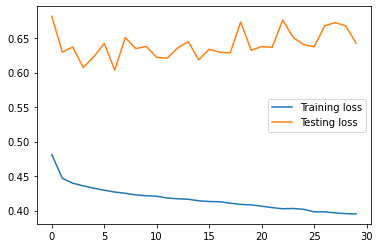

In [8]:
zero_houses = list(clustered_df[clustered_df['Cluster'] == 0]['House'])
zero_cluster = Cluster(zero_houses)
zero_cluster.consumption_df_list[2]
zero_cluster.train_model()

In [9]:
zeroCluster = jsonpickle.encode(zero_cluster)
zeroClusterJSON = json.dumps(zeroCluster)

2022-02-06 20:49:29.410002: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://525ac69f-7226-47f5-894c-f0a591213ee5/assets


In [10]:
# with open('Models/Objects/zero_cluster.json', 'w') as f:
#     json.dump(zeroCluster, f)

In [11]:
zero = jsonpickle.decode(zeroClusterJSON)

In [12]:
zeroPickled = pickle.dumps(zero_cluster)

INFO:tensorflow:Assets written to: ram://3b672880-9c77-465e-849e-27d5af6431ac/assets


INFO:tensorflow:Assets written to: ram://3b672880-9c77-465e-849e-27d5af6431ac/assets


In [13]:
zero = pickle.loads(zeroPickled)

In [14]:
type(zero)

__main__.Cluster

In [15]:
with open('Models/Objects/zero_cluster', 'wb') as f:
    pickle.dump(zero_cluster, f)

INFO:tensorflow:Assets written to: ram://fc48c197-3a51-40fc-ad94-fd4af2015d1d/assets


INFO:tensorflow:Assets written to: ram://fc48c197-3a51-40fc-ad94-fd4af2015d1d/assets


In [16]:
zero_cluster